# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Импорт необходимых библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

## Откройте и изучите файл

In [2]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('users_behavior.csv')

Построим диаграммы рассеяния для всех пар признаков, чтобы отметить степень их корреляции друг с другом. 

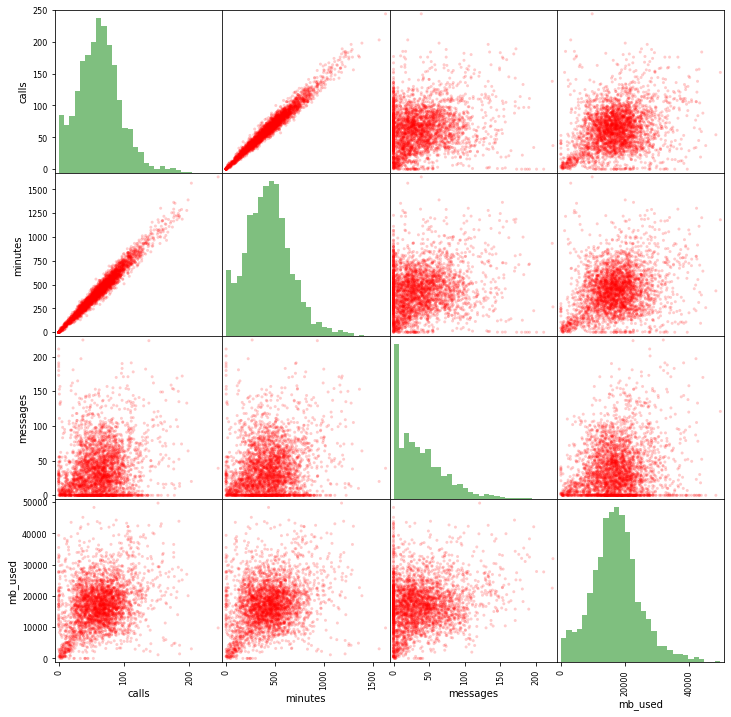

In [3]:
pd.plotting.scatter_matrix(data.loc[:,~data.columns.isin(["is_ultra"])], 
                           figsize=(12, 12), 
                           diagonal='hist',
                           hist_kwds = {'bins': 30, 
                                        'color': 'green', 
                                        'alpha': 0.5} ,
                           alpha=0.2,
                           color='red'
                           );

Очевидно, что между минутами и звонками сильная корреляция, поэтому эти параметры лишь усложнят модель, но не придадут ей точности. Поэтому от одного из параметров стоит избавиться. Судя по гистограмме, оба признака довольно нормально распределены, поэтому избавиться можно от любого из них. Удалим признак `calls`, чтобы оставить три параметра, определящих состав пакета: минуты, сообщения и мегабайты интернета

## Разбейте данные на выборки

Разделим обучающую, валидационную и тестовую выборки в пропорции 3:1:1 в два этапа. Снача отделим обучающую выборку от проверочных, а потом разделим проверочную пополам.

In [4]:
features = data[['minutes','messages','mb_used']]
target = data['is_ultra']

In [5]:
train_features, temp_features, train_target, temp_target = train_test_split(features, 
                                                                            target, 
                                                                            train_size=0.6, 
                                                                            random_state=686)

valid_features, test_features, valid_target, test_target = train_test_split(temp_features, 
                                                                            temp_target, 
                                                                            train_size=0.5, 
                                                                            random_state=686)

In [6]:
train_features.shape

(1928, 3)

In [7]:
valid_features.shape

(643, 3)

In [8]:
test_features.shape

(643, 3)

## Модель дерево решений

Обучим модель по алгоритму "Дерево решений". Для этого применим метод "брутфорс", то есть в цикле (не очень вдумчиво) переберем все сочетания гиперапараметров в надежде, что оптимум по каждому скрыт где-то на рассматриваемом интервале.

In [9]:
tree_list = []
splitters = ['best', 'random']
criterions = ['gini', 'entropy']
depths = [4, 6, 8, 10]
splits = [2, 3 ,5]
weights = [0, 0.2, 0.5]
max_features = ['auto', 'sqrt', 'log2']
leaf_nodes = [None, 2, 6, 10]
min_impurity_decreases = [0, 2, 4]

for criterion in criterions:
    for splitter in splitters:
        for depth in depths:
            for split in splits:
                for weight in weights:
                    for features in max_features:
                        for leaf_nodes_number in leaf_nodes:
                            for min_impurity_decrease in min_impurity_decreases:

                                tree_model = DecisionTreeClassifier(random_state=12345,
                                                                    criterion=criterion,
                                                                    splitter=splitter,
                                                                    max_depth=depth,
                                                                    min_samples_split=split,
                                                                    min_weight_fraction_leaf = weight,
                                                                    max_features=features,
                                                                    max_leaf_nodes = leaf_nodes_number,
                                                                    min_impurity_decrease=min_impurity_decrease
                                                                    )

                                tree_model.fit(train_features, train_target)
                                accuracy = round(tree_model.score(valid_features, valid_target),4)
                                tree_list.append([criterion, 
                                            splitter, 
                                            depth, 
                                            split, 
                                            weight, 
                                            features, 
                                            leaf_nodes_number, 
                                            min_impurity_decrease, 
                                            accuracy])

tree_results = pd.DataFrame(tree_list, columns = ['criterion', 
                                                  'splitter', 
                                                  'max_depth', 
                                                  'min_samples_split', 
                                                  'weight', 
                                                  'max_features', 
                                                  'leaf_nodes_number',
                                                  'min_impurity_decrease',
                                                  'accuracy'])

In [10]:
tree_results.sort_values(by='accuracy', ascending=False)

,criterion,splitter,max_depth,min_samples_split,weight,max_features,leaf_nodes_number,min_impurity_decrease,accuracy
3357,entropy,best,8,3,0.0,auto,10.0,0,0.8149
777,gini,best,8,3,0.0,sqrt,10.0,0,0.8149
657,gini,best,8,2,0.0,auto,10.0,0,0.8149
3585,entropy,best,10,2,0.0,sqrt,10.0,0,0.8149
669,gini,best,8,2,0.0,sqrt,10.0,0,0.8149
...,...,...,...,...,...,...,...,...,...
2001,gini,random,8,2,0.2,sqrt,10.0,0,0.6563
2000,gini,random,8,2,0.2,sqrt,6.0,4,0.6563
1999,gini,random,8,2,0.2,sqrt,6.0,2,0.6563
1998,gini,random,8,2,0.2,sqrt,6.0,0,0.6563


Видно, что в большинстве случае оптимальной является глубина дерева, равная 6. 

## Модель случайный лес

Аналогично обучим модель по алгоритму случайного леса

In [11]:
%%time

random_forest_list = []

n_estimators = [8, 10, 12, 14]
criterions = ['gini', 'entropy']
depths = [2, 4, 6, 8, 10]
splits = [2, 3 ,5]
weights = [0, 0.3, 0.5]
max_features = ['auto', 'sqrt', 'log2']
leaf_nodes = [None, 2, 6, 10]
min_impurity_decreases = [0, 2, 4]

for n_estimator in n_estimators:
    for criterion in criterions:
        for depth in depths:
            for split in splits:
                for weight in weights:
                    for features in max_features:
                        for leaf_nodes_number in leaf_nodes:
                            for min_impurity_decrease in min_impurity_decreases:

                                random_forest_model = RandomForestClassifier(random_state=12345,
                                                                    n_estimators=n_estimator,
                                                                    criterion=criterion,
                                                                    max_depth=depth,
                                                                    min_samples_split=split,
                                                                    min_weight_fraction_leaf = weight,
                                                                    max_features=features,
                                                                    max_leaf_nodes = leaf_nodes_number,
                                                                    min_impurity_decrease=min_impurity_decrease
                                                                    )

                                random_forest_model.fit(train_features, train_target)
                                accuracy = round(random_forest_model.score(valid_features, valid_target),4)
                                random_forest_list.append([n_estimator,
                                            criterion, 
                                            depth, 
                                            split, 
                                            weight, 
                                            features, 
                                            leaf_nodes_number, 
                                            min_impurity_decrease, 
                                            accuracy])


random_forest_results = pd.DataFrame(random_forest_list, columns = ['n_estimators',
                                                                    'criterion', 
                                                                    'max_depth', 
                                                                    'min_samples_split', 
                                                                    'weight', 
                                                                    'max_features', 
                                                                    'leaf_nodes_number',
                                                                    'min_impurity_decrease',
                                                                    'accuracy'])

Wall time: 4min 15s


In [12]:
random_forest_results.sort_values(by='accuracy', ascending=False)

,n_estimators,criterion,max_depth,min_samples_split,weight,max_features,leaf_nodes_number,min_impurity_decrease,accuracy
10920,14,gini,8,5,0.0,sqrt,NaN,0,0.8180
10908,14,gini,8,5,0.0,auto,NaN,0,0.8180
10932,14,gini,8,5,0.0,log2,NaN,0,0.8180
1536,8,gini,10,5,0.0,log2,NaN,0,0.8165
1524,8,gini,10,5,0.0,sqrt,NaN,0,0.8165
...,...,...,...,...,...,...,...,...,...
5104,10,entropy,2,5,0.0,log2,2.0,2,0.6563
5105,10,entropy,2,5,0.0,log2,2.0,4,0.6563
712,8,gini,6,2,0.3,log2,2.0,2,0.6563
5107,10,entropy,2,5,0.0,log2,6.0,2,0.6563


Добьемся тех же результатов, используя инструмент перебора гиперпараметров GridSearchCV

In [13]:
n_estimators = [8, 10, 12, 14]
criterions = ['gini', 'entropy']
depths = [2, 4, 6, 8, 10]
splits = [2, 3 ,5]
weights = [0, 0.3, 0.5]
max_features = ['auto', 'sqrt', 'log2']
leaf_nodes = [None, 2, 6, 10]
min_impurity_decreases = [0, 2, 4]

In [14]:
another_random_forest_model = RandomForestClassifier(random_state=12345)
hyper_params = {'n_estimators' : [8, 10, 12, 14],
          'criterion' : ['gini', 'entropy'],
          'max_depth' : [2, 4, 6, 8, 10],
          'min_samples_split' : [2, 3 ,5],
          'min_weight_fraction_leaf' : [0, 0.3, 0.5],
          'max_features' : ['auto', 'sqrt', 'log2'],
          'max_leaf_nodes': [None, 2, 6, 10],
          'min_impurity_decrease' : [0, 2, 4]
         }

In [15]:
%%time

grid = GridSearchCV(another_random_forest_model, hyper_params, cv=3)
grid.fit(train_features, train_target)

Wall time: 12min 43s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 2, 6, 10],
                         'min_impurity_decrease': [0, 2, 4],
                         'min_samples_split': [2, 3, 5],
                         'min_weight_fraction_leaf': [0, 0.3, 0.5],
                         'n_estimators': [8, 10, 12, 14]})

In [16]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 14}

In [17]:
one_more_random_forest_model = RandomForestClassifier(random_state=12345,
                                    n_estimators=10,
                                    criterion='entropy',
                                    max_depth=8,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf = 0,
                                    max_features='auto',
                                    max_leaf_nodes = None,
                                    min_impurity_decrease=0
                                    )

one_more_random_forest_model.fit(train_features, train_target)
accuracy = round(one_more_random_forest_model.score(valid_features, valid_target),4)

print(accuracy)

0.8009


Accuracy с инструментом GridSearchCV получилась ниже. Убедимся, что такой набор гиперпараметров был нами рассмотрен в ручном переборе 

In [18]:
random_forest_results.query('criterion=="entropy" and max_depth==8 and min_samples_split==2 and n_estimators==10').sort_values(by='accuracy', ascending=False).head(3)

,n_estimators,criterion,max_depth,min_samples_split,weight,max_features,leaf_nodes_number,min_impurity_decrease,accuracy
5865,10,entropy,8,2,0.0,log2,10.0,0,0.8118
5841,10,entropy,8,2,0.0,auto,10.0,0,0.8118
5853,10,entropy,8,2,0.0,sqrt,10.0,0,0.8118


Такой набор параметров рассмотрен был, но по метрике accuracy оказался хуже. Посмотрим, как GridSearchCV оценил эффективность самой эффективной, по его мнению, модели

In [19]:
grid.best_score_.round(6)

0.803424

Найдем это значение в датафрейме

In [20]:
GridSearchCV_results = pd.DataFrame(grid.cv_results_).loc[:, ~pd.DataFrame(grid.cv_results_).columns.isin(['params'])]
GridSearchCV_results.sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_split,param_min_weight_fraction_leaf,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6051,0.028254,0.000476,0.004309,4.798871e-04,gini,10,log2,None,0,2,0,14,0.805599,0.799378,0.805296,0.803424,0.002864,1
5187,0.023593,0.000463,0.003668,4.545118e-04,gini,10,auto,None,0,2,0,14,0.805599,0.799378,0.805296,0.803424,0.002864,1
5619,0.023618,0.000479,0.003310,4.559928e-04,gini,10,sqrt,None,0,2,0,14,0.805599,0.799378,0.805296,0.803424,0.002864,1
6050,0.023932,0.000005,0.003991,4.052337e-07,gini,10,log2,None,0,2,0,12,0.804044,0.799378,0.800623,0.801348,0.001973,4
5186,0.020949,0.000004,0.002989,5.524364e-06,gini,10,auto,None,0,2,0,12,0.804044,0.799378,0.800623,0.801348,0.001973,4


GridSearchCV оценивает точность по метрике `mean_test_score` и ранжирует все модели по `rank_test_score`.

Ради интереса посмотрим, какой `mean_test_score` у набора параметров, который оказался наиболее эффективным при ручном переборе

In [21]:
GridSearchCV_results.query('param_criterion=="gini" and param_max_depth in ([8,10]) and param_n_estimators in([8, 14]) and param_min_samples_split==5').sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_split,param_min_weight_fraction_leaf,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3915,0.021294,4.652581e-04,0.003311,0.000482,gini,8,auto,None,0,5,0,14,0.791602,0.793157,0.789720,0.791493,0.001405,178
4779,0.026592,2.614581e-03,0.003644,0.000461,gini,8,log2,None,0,5,0,14,0.791602,0.793157,0.789720,0.791493,0.001405,178
4347,0.026263,9.411110e-04,0.003990,0.000002,gini,8,sqrt,None,0,5,0,14,0.791602,0.793157,0.789720,0.791493,0.001405,178
4131,0.023936,5.469211e-06,0.003977,0.000016,gini,8,auto,6,0,5,0,14,0.782271,0.802488,0.788162,0.790974,0.008490,241
5859,0.024935,9.733398e-07,0.003977,0.000015,gini,10,sqrt,6,0,5,0,14,0.782271,0.802488,0.788162,0.790974,0.008490,241


Конец первой сотни. Скорее всего это связано со множественной перекрестной проверкой модели в GridSearchCV или просто с разными метриками.

## Логистическая регрессия

В логистической регрессии не все гиперпараметры сочетаются друг с другом, поэтому переберем лишь некоторые из них

In [22]:
log_regression_list = []

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalties = ['l1', 'l2', 'elasticnet', 'none']

for solver in solvers:
    for penalty in penalties:
        try:
            log_regression_model = LogisticRegression(random_state=12345, solver=solver, penalty=penalty)

            log_regression_model.fit(train_features, train_target)
            accuracy = round(log_regression_model.score(valid_features, valid_target),4)
            log_regression_list.append([penalty, solver, accuracy])
        except:
            continue

log_regression_results = pd.DataFrame(log_regression_list, columns = ['penalty', 'solver', 'accuracy'])

C:\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\an

In [23]:
log_regression_results.sort_values(by='accuracy', ascending=False)

,penalty,solver,accuracy
0,l2,newton-cg,0.7356
1,none,newton-cg,0.7356
2,l2,lbfgs,0.7356
3,none,lbfgs,0.7356
4,l1,liblinear,0.7309
5,l2,liblinear,0.6594
6,l2,sag,0.6563
7,none,sag,0.6563
8,l1,saga,0.6563
9,l2,saga,0.6563


Судя по предупреждениям, не на всех моделях достигнута сходимость, поэтому исследуем по порядку отдельно самые эффективные сочетания гиперпараметров с увеличенным числом итераций для сходимости.

In [24]:
log_regression_model = LogisticRegression(random_state=12345, penalty='l2', solver='newton-cg', max_iter=10e6)
log_regression_model.fit(train_features, train_target)
accuracy = round(log_regression_model.score(valid_features, valid_target),4)
print('Точность логистической регрессии при penalty=l2 и решателе newton-cg составляет', accuracy)

C:\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Точность логистической регрессии при penalty=l2 и решателе newton-cg составляет 0.7356


C:\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


При таком сочетании гиперпараметров сходимость не достигнута. Перейдем к исследованию второй по эффективности модели

In [25]:
log_regression_model = LogisticRegression(random_state=12345, penalty='l1', solver='liblinear', max_iter=10e6)
log_regression_model.fit(train_features, train_target)
accuracy = round(log_regression_model.score(valid_features, valid_target),4)
print('Точность логистической регрессии при penalty=l1 и решателе liblinear составляет', accuracy)

Точность логистической регрессии при penalty=l1 и решателе liblinear составляет 0.7309


### Вывод

Наилучшая точность модели достигнута на алгоритме "Случайный лес". Это было ожидаемо, поскольку этот алгоритм опирается на решения нескольких деревьев, и такой "коллективный разум" всегда оказывается точнее. Логистическая регрессия содержит меньше параметров, поэтому работает довольно быстро, но в нашем случае показывает худщий из всех результат

## Проверьте модель на тестовой выборке

Самую высокую точность показали модели случайных лесов, при этом их точность оценивалась, по-видимому, по разным метрикам, и при этом эффективности обеих моделей оказались схожи, поэтому протестируем их обе на тестовой выборке. На этот раз добавим к обучающей выборке валидационные данные.

In [26]:
another_random_forest_model.fit(train_features.append(valid_features), train_target.append(valid_target))
test_accuracy = round(another_random_forest_model.score(test_features, test_target),3)
print('Accuracy выбранной модели на тестовой выборке составляет', test_accuracy)

Accuracy выбранной модели на тестовой выборке составляет 0.804


In [27]:
one_more_random_forest_model.fit(train_features.append(valid_features), train_target.append(valid_target))
test_accuracy = round(one_more_random_forest_model.score(test_features, test_target),3)
print('Accuracy выбранной модели на тестовой выборке составляет', test_accuracy)

Accuracy выбранной модели на тестовой выборке составляет 0.792


Точность моделей на тестовой выборке отличается меньше, чем на 1%.

## (бонус) Проверьте модели на адекватность

Проверим модель на адекватность. В качестве финальной модели возьмем тут модель случайного леса, которая на тестовой выборке показала наилучший результат.

Рассмотрим уникальные значения, генерируемые моделью

In [28]:
print(set(one_more_random_forest_model.predict(test_features)))

{0, 1}


Классы в выборке представлены неравномерно, поэтому если опираться на нее, то даже без всякой модели присваивая всем наблюдениям в тестовой и валидационной выборке код преобладающего класса, можно достичь accuracy выше 50%. Определим пороговое адекватное значение.

In [29]:
(data.query('is_ultra==0')['is_ultra'].count() / data.shape[0]).round(4)

0.6935

Точность обученной модели примерно на 10% выше случайного угадывания, слава богу.

Проведем примерно тот же анализ при помощи встроенного в sklearn инструмента DummyClassifier, который возвращает классифицированные данные, опираясь на некоторые статистические характеристики выборки. В нашем случае выберем в качестве strategy вариант `most_frequent`, который всегда возвращает значение доминирующего класса.

In [30]:
dc = DummyClassifier(strategy = 'most_frequent', random_state = 54321)

dc.fit(train_features, train_target)
dc.score(test_features, test_target).round(4)

0.6905

Похоже